In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n/assignments/assignment3/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment3/cs231n/datasets
/content


# Network Visualization (TensorFlow)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **TensorFlow**; we have provided another notebook which explores the same concepts in PyTorch. You only need to complete one of these two notebooks.

In [2]:
# As usual, a bit of setup
import sys
sys.path.append('../')
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

We have ported the PyTorch SqueezeNet model to TensorFlow; see: `cs231n/classifiers/squeezenet.py` for the model architecture.

To use SqueezeNet, you will need to first **download the weights** by descending into the `cs231n/datasets` directory and running `get_squeezenet_tf.sh`. Note that if you ran `get_assignment3_data.sh` then SqueezeNet will already be downloaded.

Once you've downloaded the Squeezenet model, we can load it into a new TensorFlow session:  

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

**NOTE:**  Ignore Tensorflow warnings from the cell below

In [ ]:
%cd drive/My Drive/cs231n/assignments/assignment3/cs231n/datasets

/content/drive/My Drive/cs231n/assignments/assignment3/cs231n/datasets


In [ ]:
!bash get_squeezenet_tf.sh

--2020-09-17 20:23:24--  http://cs231n.stanford.edu/squeezenet_tf2.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4592284 (4.4M) [application/zip]
Saving to: ‘squeezenet_tf2.zip’

squeezenet_tf2.zip  100%[===================>]   4.38M  4.69MB/s    in 0.9s    

2020-09-17 20:23:25 (4.69 MB/s) - ‘squeezenet_tf2.zip’ saved [4592284/4592284]

Archive:  squeezenet_tf2.zip
  inflating: squeezenet.ckpt.data-00000-of-00001  
  inflating: squeezenet.ckpt.index   


In [3]:
SAVE_PATH = None

# Local
#SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'

# Colab
SAVE_PATH = '/content/drive/My Drive/{}/{}'.format(FOLDERNAME, 'cs231n/datasets/squeezenet.ckpt')

assert SAVE_PATH is not None, "[!] Choose path to squeezenet.ckpt"

if not os.path.exists(SAVE_PATH + ".index"):
    raise ValueError("You need to download SqueezeNet!")

model = SqueezeNet()
status = model.load_weights(SAVE_PATH)

model.trainable = False


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd00819a6a0> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd00819aa90>).

Two checkpoint references resolved to different objects (<cs231n.classifiers.squeezenet.Fire object at 0x7fd00819ac88> and <cs231n.classifiers.squeezenet.Fire object at 0x7fd001c86828>).

Two checkpoint references resolved to different objects (<cs231n.classifiers.squeezenet.Fire object at 0x7fd001c86828> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd001c92390>).

Two checkpoint references resolved to different objects (<cs231n.classifiers.squeezenet.Fire object at 0x7fd001c92588> and <cs231n.classifiers.squeezenet.Fire object at 0x7fd001c9a128>).

Two checkpoint references resolved to different objects (<cs231n.classifiers.squeezenet.Fire object at 0x7fd001c9a128> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd001c9

## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

In [ ]:
!bash get_imagenet_val.sh

--2020-09-17 20:24:44--  http://cs231n.stanford.edu/imagenet_val_25.npz
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [text/plain]
Saving to: ‘imagenet_val_25.npz’

imagenet_val_25.npz 100%[===================>]   3.76M  5.44MB/s    in 0.7s    

2020-09-17 20:24:45 (5.44 MB/s) - ‘imagenet_val_25.npz’ saved [3940548/3940548]



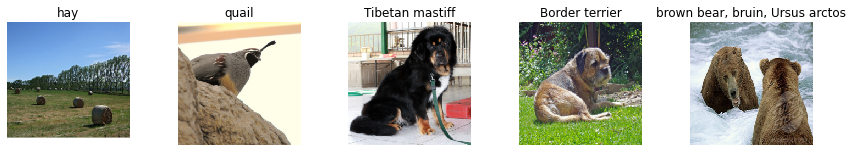

In [4]:
from cs231n.data_utils import load_imagenet_val
X_raw, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Preprocess images
The input to the pretrained model is expected to be normalized, so we first preprocess the images by subtracting the pixelwise mean and dividing by the pixelwise standard deviation.

In [5]:
X = np.array([preprocess_image(img) for img in X_raw])

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

Open the file `cs231n/classifiers/squeezenet.py` and read the code to make sure you understand how to use the model. You will have to use [`tf.GradientTape()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape) to compute gradients with respect to the pixels of the image. In particular, it will be very useful to read this [section](https://www.tensorflow.org/alpha/tutorials/eager/automatic_differentiation#gradient_tapes) for better understanding.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

Implement ```compute_saliency_maps``` function inside ```cs231n/net_visualization_tensorflow.py```

### Hint: Tensorflow `gather_nd` method
Recall in Assignment 1 you needed to select one element from each row of a matrix; if `s` is a numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In Tensorflow you can perform the same operation using the `gather_nd()` method. If `s` is a Tensor of shape `(N, C)` and `y` is a Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`tf.gather_nd(s, tf.stack((tf.range(N), y), axis=1))`

will be a Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

You can also read the documentation for the [gather_nd method](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/gather_nd).

Once you have completed the implementation above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

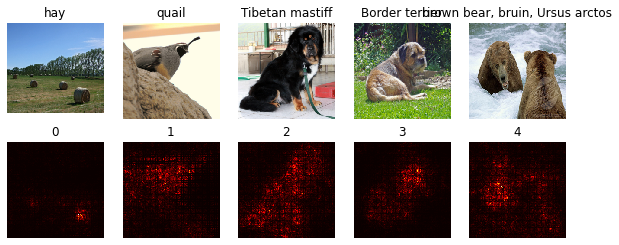

In [ ]:
from cs231n.net_visualization_tensorflow import compute_saliency_maps
def show_saliency_maps(X, y, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    saliency = compute_saliency_maps(Xm, ym, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()

mask = np.arange(5)
show_saliency_maps(X, y, mask)

# INLINE QUESTION

A friend of yours suggests that in order to find an image that maximizes the correct score, we can perform gradient ascent on the input image, but instead of the gradient we can actually use the saliency map in each step to update the image. Is this assertion true? Why or why not?

**Your Answer:** 

We have taken the absolute value of the gradient, so the information about what "direction" we should move toward in each pixel in order to increase the score is mostly lost. We have also taken the maximum value among the three color-channel pixel so we wouldn't know either which is the one to tweak in the path towards max score. 

That assertion is thus not true and we would be better off by using the actual gradient before processing it into saliency map. (Those steps are only taken so as to have nice images.) 



# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

Implement ```make_fooling_image``` function inside ```cs231n/net_visualization_tensforflow.py```


Run the following to generate a fooling image. You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

In [9]:
np.array([[1,2,3]])[0]

array([1, 2, 3])

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13


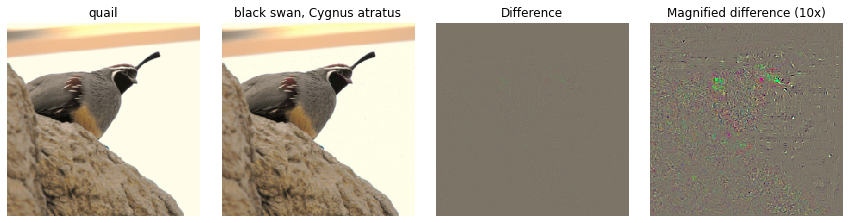

In [64]:
from cs231n.net_visualization_tensorflow import make_fooling_image

idx = 1
Xi = X[idx][None]
target_y = 100
X_fooling = make_fooling_image(Xi, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = model(X_fooling)
assert tf.math.argmax(scores[0]).numpy() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
orig_img = deprocess_image(Xi[0])
fool_img = deprocess_image(X_fooling[0])
plt.figure(figsize=(12, 6))

# Rescale 
plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.axis('off')
plt.title(class_names[y[idx]])
plt.subplot(1, 4, 2)
plt.imshow(fool_img)
plt.title(class_names[target_y])
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Difference')
plt.imshow(deprocess_image((Xi-X_fooling)[0]))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Magnified difference (10x)')
plt.imshow(deprocess_image(10 * (Xi-X_fooling)[0]))
plt.axis('off')
plt.gcf().tight_layout()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = {\arg\max}_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop


In `cs231n/net_visualization_tensorflow.py` complete the implementation of the `image_visualization_update_step` used in the `create_class_visualization` function below.
Once you have completed that implementation, run the following cells to generate an image of a Tarantula:

In [68]:
from cs231n.net_visualization_tensorflow import class_visualization_update_step, jitter, blur_image

def create_class_visualization(target_y, model, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    
    # We use a single image of random noise as a starting point
    X = 255 * np.random.rand(224, 224, 3)
    X = preprocess_image(X)[None]

    loss = None # scalar loss
    grad = None # gradient of loss with respect to model.image, same size as model.image
    
    X = tf.Variable(X)
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(0, max_jitter, 2)
        X = jitter(X, ox, oy)
        X = class_visualization_update_step(X, model, target_y, l2_reg, learning_rate)
        # Undo the jitter
        X = jitter(X, -ox, -oy)
        # As a regularizer, clip and periodically blur
        
        X = tf.clip_by_value(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess_image(X[0]))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
    return X

Once you have completed the implementation in the cell above, run the following cell to generate an image of Tarantula:

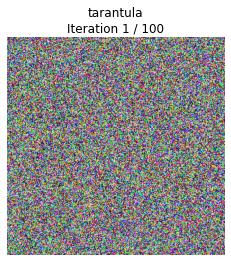

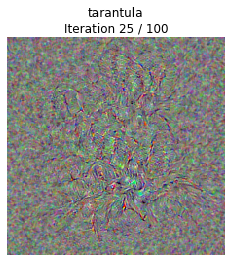

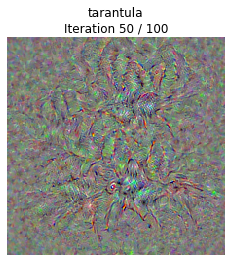

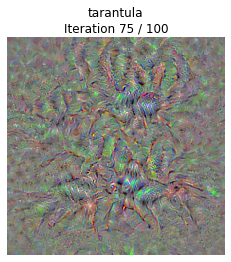

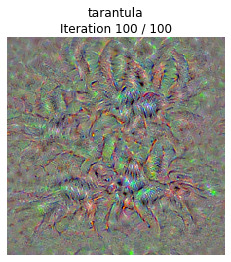

In [69]:
target_y = 76 # Tarantula
out = create_class_visualization(target_y, model)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

hourglass


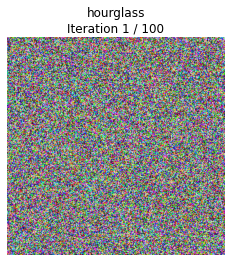

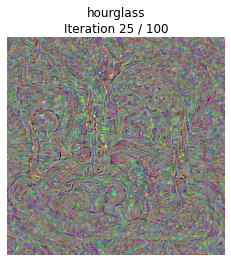

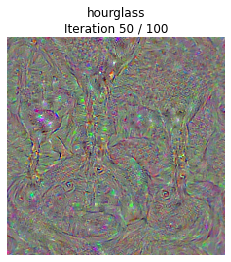

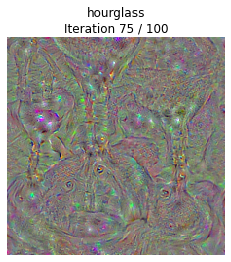

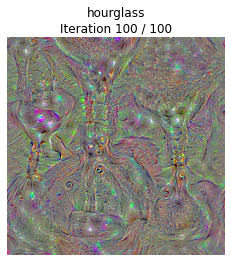

In [76]:
#target_y = np.random.randint(1000)
#target_y = 78 # Tick
#target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
#target_y = 366 # Gorilla
target_y = 604 # Hourglass
print(class_names[target_y])
X = create_class_visualization(target_y, model)